<a href="https://colab.research.google.com/github/johanhoffman/DD2363-VT20/blob/master/template-report-Navier-Stokes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The Navier-Stokes equations**
**Johan Hoffman**

# **Abstract**

This short report show an example on how to use FEniCS to solve the Stokes equations, which is used in the course DD2365 Advanced Computation in Fluid Mechanics, at the KTH Royal Institute of Technology.

[DD2365 course website.](https://kth.instructure.com/courses/17071)

#**About the code**

A short statement on who is the author of the file, and if the code is distributed under a certain license. 

In [0]:
"""This program is an example file for the course"""
"""DD2365 Advanced Computation in Fluid Mechanics, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2020 Johan Hoffman (jhoffman@kth.se)

# This file is part of the course DD2365 Advanced Computation in Fluid Mechanics
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This template is maintained by Johan Hoffman
# Please report problems to jhoffman@kth.se

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

To have access to the neccessary modules you have to run this cell. If you need additional modules, this is where you add them. 

In [0]:
# Load neccessary modules.
from google.colab import files

import time
import numpy as np

try:
    from dolfin import *; from mshr import *
except ImportError as e:
    !apt-get install -y -qq software-properties-common 
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics
    from dolfin import *; from mshr import *
    
import dolfin.common.plotting as fenicsplot

from matplotlib import pyplot as plt
from matplotlib import tri
from matplotlib import axes
from mpl_toolkits.mplot3d import Axes3D

# **Introduction**

The Poisson equation takes the form

$-\Delta u = f$

together with suitable boundary conditions. 


# **Method**

In [0]:
# Define domain
L = 4
H = 1

# Define subdomains
class Left(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], 0.0) 

class Right(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], L)

class Lower(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], 0.0)

class Upper(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], H)
      
left = Left()
right = Right()
lower = Lower()
upper = Upper()

resolution = 16

# Generate mesh 
mesh = RectangleMesh(Point(0.0, 0.0), Point(L, H), L*resolution, H*resolution)
#mesh = generate_mesh(Rectangle(Point(0.0,0.0), Point(L,H)) - Circle(Point(0.5,0.5*H),0.2), resolution)

# Refine mesh
no_levels = 0
for i in range(0,no_levels):
  cell_marker = MeshFunction("bool", mesh, mesh.topology().dim())
  for cell in cells(mesh):
    cell_marker[cell] = False
    p = cell.midpoint()
    if p.distance(Point(0.5, 0.5)) < 1.0:
        cell_marker[cell] = True
  mesh = refine(mesh, cell_marker)

#plot(Q.mesh())

# Define mesh functions 
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim()-1)
boundaries.set_all(0)
left.mark(boundaries, 1)
right.mark(boundaries, 2)
lower.mark(boundaries, 3)
upper.mark(boundaries, 4)

In [0]:
# Generate finite element spaces
#VE = VectorElement("CG", mesh.ufl_cell(), 1)
#QE = FiniteElement("CG", mesh.ufl_cell(), 1)
#WE = VE * QE

#W = FunctionSpace(mesh, WE)
#V = FunctionSpace(mesh, VE)
#Q = FunctionSpace(mesh, QE)

V = VectorFunctionSpace(mesh, "Lagrange", 1)
Q = FunctionSpace(mesh, "Lagrange", 1)
K = FunctionSpace(mesh, "Discontinuous Lagrange", 0)

# Define trial and test functions 
#(u, p) = TrialFunctions(W)
#(v, q) = TestFunctions(W)
u = TrialFunction(V)
p = TrialFunction(Q)
v = TestFunction(V)
q = TestFunction(Q)

In [0]:
# Define boundary conditions 
class DirichletBoundaryLower(SubDomain):
    def inside(self, x, on_boundary):
        #return bool(x[1] < DOLFIN_EPS and on_boundary)
        return on_boundary and near(x[1], 0.0)

class DirichletBoundaryUpper(SubDomain):
    def inside(self, x, on_boundary):
        #return bool(x[1] > (H - DOLFIN_EPS) and on_boundary)
        return on_boundary and near(x[1], H)

class DirichletBoundaryLeft(SubDomain):
    def inside(self, x, on_boundary):
        #return bool(x[0] < DOLFIN_EPS and on_boundary)
        return on_boundary and near(x[0], 0.0) 

class DirichletBoundaryRight(SubDomain):
    def inside(self, x, on_boundary):
        #return bool(x[0] > (L - DOLFIN_EPS) and on_boundary)
        return on_boundary and near(x[0], L)

class DirichletBoundaryObjects(SubDomain):
    def inside(self, x, on_boundary):
        #return bool(x[0] > (L - DOLFIN_EPS) and on_boundary)
        return on_boundary and (not near(x[0], 0.0)) and (not near(x[0], L)) and (not near(x[1], 0.0)) and (not near(x[1], H))

dbc_lower = DirichletBoundaryLower()
dbc_upper = DirichletBoundaryUpper()
dbc_left = DirichletBoundaryLeft()
dbc_right = DirichletBoundaryRight()
dbc_objects = DirichletBoundaryObjects()

#uin = Expression('4.0*x[1]*(1-x[1])', element = V.sub(0).ufl_element())
#uin = Expression('1.0 + 1.0*fabs(sin(t))', element = V.sub(0).ufl_element(), t=0.0)
uin = 1.0
#bcuin = DirichletBC(V, (uin, 0.0), dbc_left)
bcu_in0 = DirichletBC(V.sub(0), uin, dbc_left)
bcu_in1 = DirichletBC(V.sub(1), 0.0, dbc_left)
bcu_upp0 = DirichletBC(V.sub(0), 0.0, dbc_upper)
bcu_upp1 = DirichletBC(V.sub(1), 0.0, dbc_upper)
bcu_low0 = DirichletBC(V.sub(0), 0.0, dbc_lower)
bcu_low1 = DirichletBC(V.sub(1), 0.0, dbc_lower)
bcu_obj0 = DirichletBC(V.sub(0), 0.0, dbc_objects)
bcu_obj1 = DirichletBC(V.sub(1), 0.0, dbc_objects)
#bcuw0 = DirichletBC(V, (0.0, 0.0), dbc_lower)
#bcuw1 = DirichletBC(V, (0.0, 0.0), dbc_upper)

pin = Expression('5.0*fabs(sin(t))', element = Q.ufl_element(), t=0.0)
pout = 0.0
bcp0 = DirichletBC(Q, pin, dbc_left) 
bcp1 = DirichletBC(Q, pout, dbc_right)

bcu = [bcu_in0, bcu_in1, bcu_upp0, bcu_upp1, bcu_low0, bcu_low1, bcu_obj0, bcu_obj1]
#bcu = [bcu_in0, bcu_in1, bcu_upp1, bcu_low1]
#bcu = [bcu_upp1, bcu_low1, bcu_obj0, bcu_obj1]
bcp = [bcp1]
#bcp = [bcp0, bcp1]

# **Results**

Present the results. If the result is an algorithm that you have described under the *Methods* section, you can present the data from verification and performance tests in this section. If the result is the output from a computational experiment this is where you present a selection of that data. 

In [0]:
# Set permeability matrix
Kinv11 = Expression('100.0*fabs(sin(2.0*pi*(x[1] - 0.1*x[0])))', element = K.ufl_element())
Kinv12 = Expression('0.0', element = K.ufl_element())
Kinv21 = Kinv12
Kinv22 = Kinv11

# Set viscosity
nu = 1.0e-2

# Set effective viscosity
nueff = 1.0e-2

In [0]:
# Define functions
u0 = Function(V)
u1 = Function(V)
p0 = Function(Q)
p1 = Function(Q)

# Set method parameters
num_nnlin_iter = 5 
prec = "amg" if has_krylov_solver_preconditioner("amg") else "default" 

# Time step length 
dt = 0.5*mesh.hmin() 

# Define measure for boundary integration  
ds = Measure('ds', domain=mesh, subdomain_data=boundaries)

In [0]:
# Define variational problems
#d1 = 1.0*mesh.hmin()
#d2 = 1.0*mesh.hmin()
#d3 = 1.0e-2*mesh.hmin()

h = CellDiameter(mesh);
u_mag = sqrt(dot(u1,u1))
d1 = 1.0/sqrt((pow(1.0/dt,2.0) + pow(u_mag/h,2.0)))
#d1 = h
#d2 = 0.0
d2 = h*u_mag

um = 0.5*(u + u0)
um1 = 0.5*(u1 + u0)
Fu = inner((u - u0)/dt + grad(um)*um1, v)*dx - p1*div(v)*dx + nueff*inner(grad(um), grad(v))*dx \
    + d1*inner((u - u0)/dt + grad(um)*um1 + grad(p1), grad(v)*um1)*dx + d2*div(um)*div(v)*dx \
    + nu*(Kinv11*inner(um[0],v[0])*dx + Kinv12*inner(um[0],v[1])*dx + Kinv21*inner(um[1],v[0])*dx + Kinv22*inner(um[1],v[1])*dx)
au = lhs(Fu)
Lu = rhs(Fu)

Fp = d1*inner((u1 - u0)/dt + grad(um1)*um1 + grad(p), grad(q))*dx + div(um1)*q*dx 
ap = lhs(Fp)
Lp = rhs(Fp)

# Assemble linear matrix 
# Ap = assemble(ap)

In [0]:
# Open files
file_u = File("results-BNS/u.pvd")
file_p = File("results-BNS/p.pvd")

# Set plot frequency
plot_time = 0
plot_freq = 10

rm: cannot remove 'results-BNS/*': No such file or directory
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Time t = 0.04419417382415922


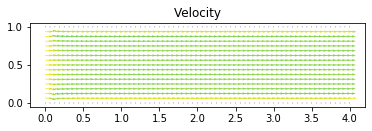

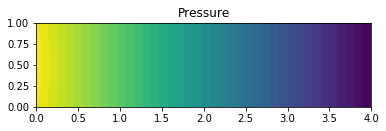

Time t = 1.0164659979556625


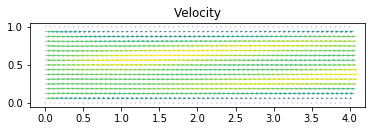

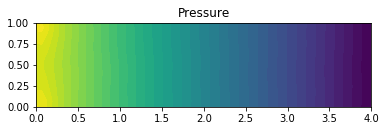

Time t = 2.032931995911323


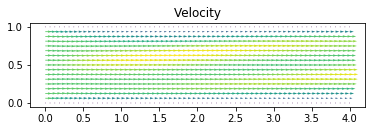

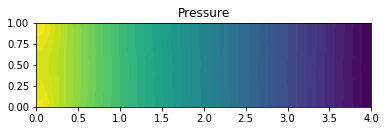

Time t = 3.0052038200428237


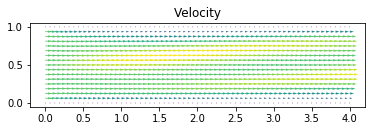

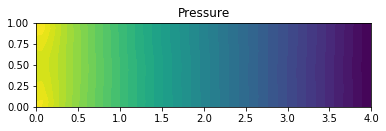

Time t = 4.021669817998484


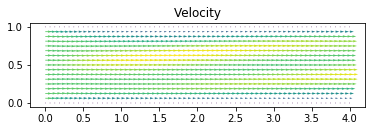

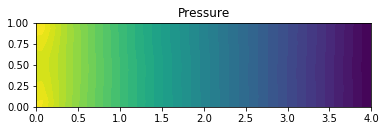

Time t = 5.0381358159541545


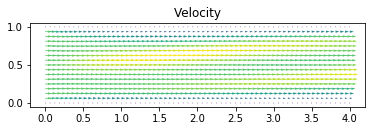

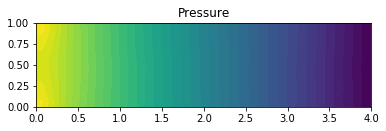

Time t = 6.010407640085665


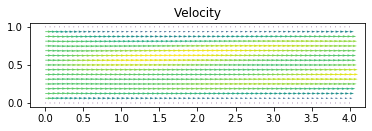

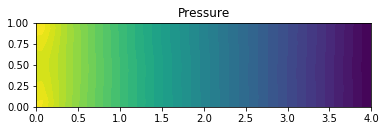

Time t = 7.0268736380413355


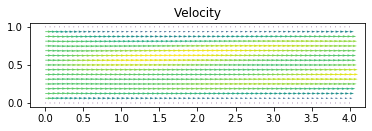

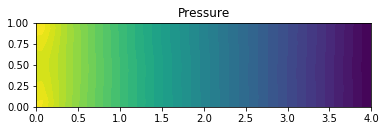

Time t = 8.043339635997006


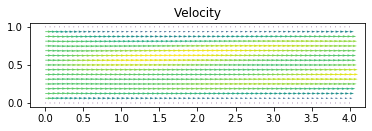

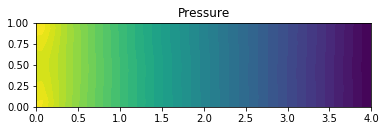

Time t = 9.015611460128516


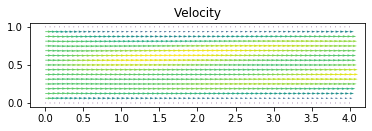

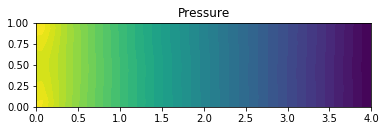

results-BNS/
results-BNS/u000007.vtu
results-BNS/u000004.vtu
results-BNS/p000000.vtu
results-BNS/p000003.vtu
results-BNS/u000008.vtu
results-BNS/p000009.vtu
results-BNS/u000009.vtu
results-BNS/p000005.vtu
results-BNS/p000002.vtu
results-BNS/u000000.vtu
results-BNS/p000001.vtu
results-BNS/u000001.vtu
results-BNS/u000006.vtu
results-BNS/u000002.vtu
results-BNS/p000007.vtu
results-BNS/u000005.vtu
results-BNS/p.pvd
results-BNS/u000003.vtu
results-BNS/p000008.vtu
results-BNS/u.pvd
results-BNS/p000004.vtu
results-BNS/p000006.vtu


In [0]:
!rm results-BNS/*

# Time stepping 
T = 10
t = dt
while t < T + DOLFIN_EPS:

    #s = 'Time t = ' + repr(t) 
    #print(s)

    pin.t = t

    # Solve non-linear problem 
    k = 0
    while k < num_nnlin_iter: 
        
        # Assemble matrix and vector 
        Au = assemble(au)
        bu = assemble(Lu)

        # Compute solution 
        [bc.apply(Au, bu) for bc in bcu]
        [bc.apply(u1.vector()) for bc in bcu]
        solve(Au, u1.vector(), bu, "bicgstab", "default")

        # Assemble matrix and vector
        Ap = assemble(ap) 
        bp = assemble(Lp)

        # Compute solution 
        [bc.apply(Ap, bp) for bc in bcp]
        [bc.apply(p1.vector()) for bc in bcp]
        solve(Ap, p1.vector(), bp, "bicgstab", prec)

        k += 1

    if t > plot_time:     
        
        s = 'Time t = ' + repr(t) 
        print(s)
    
        # Save solution to file
        file_u << u1
        file_p << p1

        # Plot solution
        plt.figure()
        plot(u1, title="Velocity")

        plt.figure()
        plot(p1, title="Pressure")

        plot_time += T/plot_freq
        
        plt.show()

    # Update time step
    u0.assign(u1)
    t += dt

plt.show()

!tar -czvf results-BNS.tar.gz results-BNS
files.download('results-BNS.tar.gz')

# **Discussion**

Summarize your results and your conclusions. Were the results expected or surprising. Do your results have implications outside the particular problem investigated in this report? 

# **APPENDIX**

In this appendix some examples are given to express and visualizing mathematical concepts such as vectors, matrices, meshes and functions. 

This is not part of the template report for the course.

# **Vector**

In this cell some basic commands are introduced for how to define and process a vector, where the NumPy array data type is used. 

x = [1 2 3 4]
x[2] = 3
x[0:2] = [1 2]
x.shape = (4,)
x.ndim = 1
x.size = 4
x.dtype = int64
x[ 0 ] = 1
x[ 1 ] = 2
x[ 2 ] = 3
x[ 3 ] = 4
x = [1 2 3 4]
xf = [1.  2.1 3.  4. ]
xf.dtype = float64
y = [2.+0.j 3.+0.j 4.+0.j]
y.dtype = complex128
z = [12.  16.5 21.  25.5]
z = [0.         1.57079633 3.14159265 4.71238898 6.28318531]


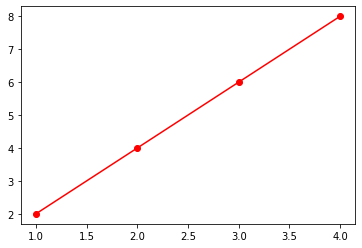

In [0]:
# Just a test
# Create a vector as a NumPy array
x = np.array([1,2,3,4])

# Print various attributes of the vector
print('x =',x)
print('x[2] =',x[2])
print('x[0:2] =',x[0:2])
print('x.shape =',x.shape)
print('x.ndim =',x.ndim)
print('x.size =',x.size)
print('x.dtype =',x.dtype)

# Print the elements of vector x
for i in range(x.size):
  print("x[",i,"] =",x[i])

# Assign a float value to the int vector x
x[1] = 2.1
print('x =',x)

# Copy the int vector x to a float vector xf
xf = x.astype(float)
xf[1] = 2.1
print('xf =',xf)
print('xf.dtype =',xf.dtype)

# Create a complex vector 
y = np.array([2,3,4], dtype=complex)
print('y =',y)
print('y.dtype =',y.dtype)

# Create a vector z by defining a range through an increment
z = np.arange(12, 28, 4.5)
print('z =',z)

# Overwrite the vector z by a vector of uniformly spaced elements in a range
pi=np.pi
pi
z = np.linspace(0, 2*pi, 5)
print('z =',z)

# Visualize the vector in a plot. 
plt.figure()
plt.plot(x,2*x,'ro-')
plt.show()

# **Matrix**

In this cell some basic commands for defining and processing a matrix
is introduced, where we use the NumPy array data type. 

A = [[2 4 6]
 [3 6 9]
 [1 2 1]]
A[1,0] = 3
A.shape = (3, 3)
A.ndim = 2
A.size = 9
Sparse matrix values: 
 [3 2 2 2 1 1 3 2 1 2 3]
Sparse matrix column indices: 
 [1 2 4 2 3 3 3 4 5 5 6]
Sparse matrix row pointer: 
 [ 1  4  6  7  9 10]


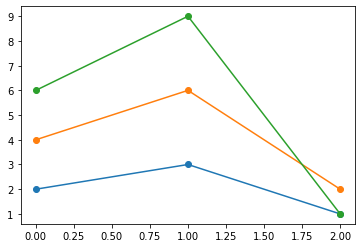

In [0]:
# Define a matrix as a NumPy array
A = np.array([[2,4,6], [3,6,9], [1,2,1]])

# Print various attributes of the matrix 
print('A =',A)
print('A[1,0] =',A[1,0])
print('A.shape =',A.shape)
print('A.ndim =',A.ndim)
print('A.size =',A.size)

# Plot the matrix
plt.figure()
plt.plot(A,'o-')

# Construct a simple sparse matrix class using the CRS data structure
class spMatrix:
  def __init__(self, val, col_idx, row_ptr):
    self.val = val
    self.col_idx = col_idx
    self.row_ptr = row_ptr
    
# Create a sparse matrix object 
val = np.array([3, 2, 2, 2, 1, 1, 3, 2, 1, 2, 3])
col_idx = np.array([1, 2, 4, 2, 3, 3, 3, 4, 5, 5, 6])
row_ptr = np.array([1, 4, 6, 7, 9, 10])
spA = spMatrix(val, col_idx, row_ptr)

# Print sparse matrix object attributes
print('Sparse matrix values: \n',spA.val)
print('Sparse matrix column indices: \n',spA.col_idx)
print('Sparse matrix row pointer: \n',spA.row_ptr)
    

# **Function**

In this cell we illustrate how functions are defined. 

f(3,4) = 7
z = 13
z = 17
z = 14
A = [[1 2 3]
 [4 5 6]
 [7 8 9]]
A =
1  2  3  
4  5  6  
7  8  9  
A^T =
1  4  7  
2  5  8  
3  6  9  


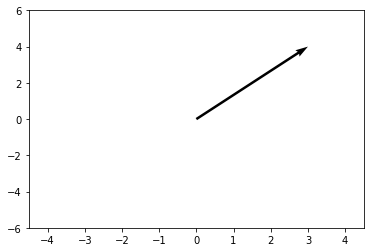

In [0]:
# Define a function f(x,y)
def f(x,y):
  return x + y 

# Verify the function output
print('f(3,4) =',f(3,4))

# Define a function of a function
def g1(fcn,arg1,arg2):
  z = fcn(arg1,arg2)
  print('z =',z)

# Call the function
g1(f,6,7)

# Define a function of a function with arguments in a list or array
def g2(fcn,arg):
  z = fcn(*arg)
  print('z =',z)
  
# Call the function with arguments as list and array
xlist = [8,9]
xarray = np.array([11,3])
g2(f,xlist)
g2(f,xarray)

# Define a function to format the print out for a matrix 
def printMatrix(A):
   rows = A.shape[0]
   cols = A.shape[1]
   for i in range(0,rows):
      for j in range(0,cols):
         print(A[i,j]," ", end='')
      print()

# Define matrix      
A = np.array([[1,2,3], [4,5,6], [7,8,9]])

# Verify the function output
print('A =', A)
print('A =')
printMatrix(A)
print('A^T =')
printMatrix(A.transpose())

# Plot a Euclidian position vector v 
def plotEVector(vec):
  plt.figure()
  plt.xlim([-1.5*vec[0], 1.5*vec[0]])
  plt.ylim([-1.5*vec[1], 1.5*vec[1]])
  plt.quiver(0, 0, vec[0], vec[1], scale=1, scale_units='xy', angles='xy')
  plt.show()

v = np.array([3,4])
plotEVector(v)




# **Plot**

<Figure size 432x288 with 0 Axes>

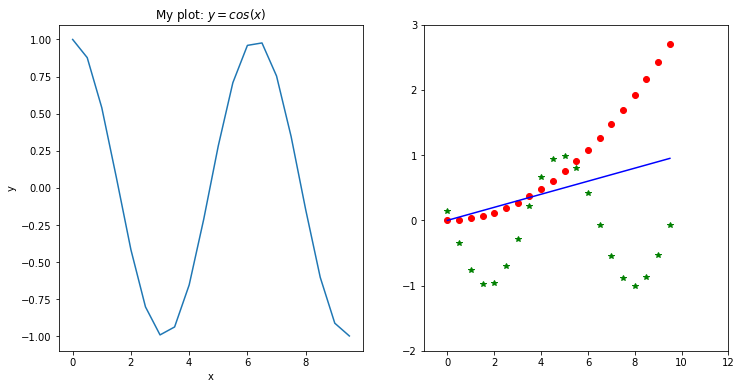

In [0]:
# Define a range for a parameter t
t = np.arange( 0.0, 10, 0.5)

# Initialize a new figure and set the size 
plt.figure(2)
plt.figure(figsize=(12,6))

# Define a subplot structure and choose the first subplot 
plt.subplot(121)

# Plot a standard NumPy function against the parameter t
plt.plot(t,np.cos(t))

# Set plot labels and title for the subplot
plt.xlabel('x')
plt.ylabel('y')
plt.title('My plot: $y = cos(x)$')

# Choose the other subplot
plt.subplot(122)

# Plot three functions in the same subplot
plt.plot(t, np.sin(f(t,3)), 'g*', t, 0.03*t**2, 'ro', t, 0.1*t, 'b')
plt.axis([-1, 12, -2 ,3])

# Show the figure
plt.show()

# Triangular **mesh**

This cell describes how to generate a triangular mesh from a point cloud by the Delaunay algorithm. It also illustrates how to access the mesh data structures. 

Mesh generation took:  0.0005655288696289062 seconds (wall-clock time)
vertices = 
 [[0.   0.25 0.5  0.75 1.   0.   0.25 0.5  0.75 1.   0.   0.25 0.5  0.75
  1.   0.   0.25 0.5  0.75 1.   0.   0.25 0.5  0.75 1.  ]
 [0.   0.   0.   0.   0.   0.25 0.25 0.25 0.25 0.25 0.5  0.5  0.5  0.5
  0.5  0.75 0.75 0.75 0.75 0.75 1.   1.   1.   1.   1.  ]]
edges = 
 [[ 1  0]
 [ 2  1]
 [ 3  2]
 [ 4  3]
 [ 5  0]
 [ 5  1]
 [ 6  1]
 [ 6  5]
 [ 7  1]
 [ 7  2]
 [ 7  3]
 [ 7  6]
 [ 8  3]
 [ 8  7]
 [ 9  3]
 [ 9  4]
 [ 9  8]
 [10  5]
 [11  5]
 [11  6]
 [11  7]
 [11 10]
 [12  7]
 [12 11]
 [13  7]
 [13  8]
 [13  9]
 [13 12]
 [14  9]
 [14 13]
 [15 10]
 [15 11]
 [16 11]
 [16 15]
 [17 11]
 [17 12]
 [17 13]
 [17 16]
 [18 13]
 [18 17]
 [19 13]
 [19 14]
 [19 18]
 [20 15]
 [21 15]
 [21 16]
 [21 17]
 [21 20]
 [22 17]
 [22 21]
 [23 17]
 [23 18]
 [23 19]
 [23 22]
 [24 19]
 [24 23]]
triangles = 
 [[ 0  1  5]
 [ 5  1  6]
 [ 9  3  4]
 [ 8  3  9]
 [ 6  1  7]
 [ 7  1  2]
 [ 7  3  8]
 [ 2  3  7]
 [20 15 21]
 [21 15 16]
 [ 6  7

<Figure size 432x288 with 0 Axes>

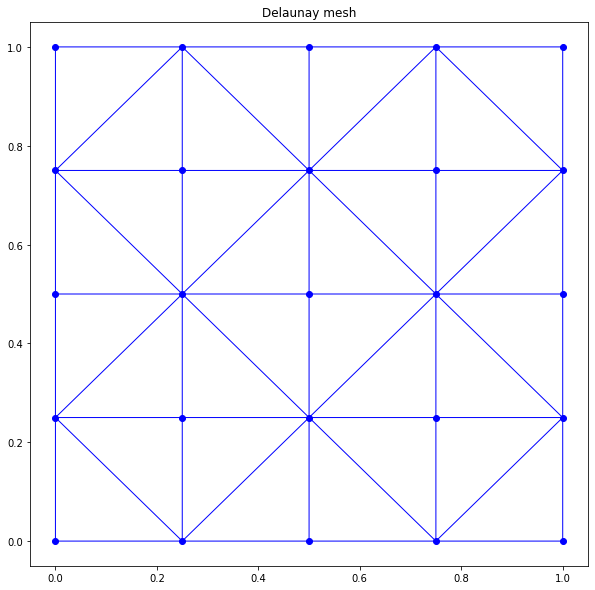

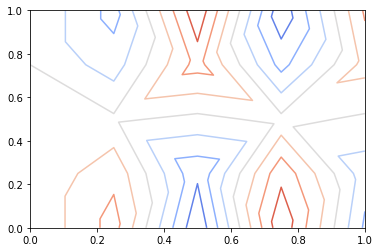

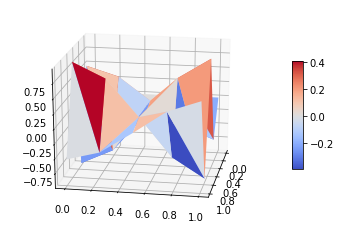

In [0]:
# Start the clock 
start = time.time()

# Generate a point cloud
Nx = 5
Ny = 5
hx = 1.0/(Nx-1)
hy = 1.0/(Ny-1)
x = np.zeros((Nx*Ny))
y = np.zeros((Nx*Ny))
for i in range(Nx):
  for j in range(Ny):
    x[i*Nx + j] = j*hx
    y[i*Nx + j] = i*hy

# Generate a mesh from the point cloud using a Delaunay algorithm
mesh = tri.Triangulation( x, y )

# Stop the clock
end = time.time()

# Print the measured time
print ("Mesh generation took: ", end - start, "seconds (wall-clock time)")

# Print mesh data structure
vertices = np.array([mesh.x, mesh.y])
print('vertices = \n', vertices)
print('edges = \n', mesh.edges)
print('triangles = \n', mesh.triangles)
print('neighbor triangles = \n', mesh.neighbors)

# Plot the mesh 
plt.figure(3)
plt.figure(figsize=(10,10))
plt.triplot(mesh, 'bo-', lw=1)
plt.title('Delaunay mesh')
plt.show()

# Define a function g(x,y)
def g(x,y):
    return np.sin(10*x)*np.cos(3*y)

# Plot the function g(x,y) in a contour plot
plt.figure(4)
plt.tricontour(mesh, g(x,y), cmap=plt.cm.coolwarm)
plt.show()

# Plot the function g(x,y) in 3D as a surface plot
fig = plt.figure(5)
ax1 = fig.add_subplot(111, projection='3d')
surf = ax1.plot_trisurf(mesh, g(x,y), cmap=plt.cm.coolwarm)
fig.colorbar(surf, shrink=0.5, aspect=10)
ax1.view_init(20,10)
plt.show()

# Parametric **curve**

This cell illustrates how to visualize a parametric curve.

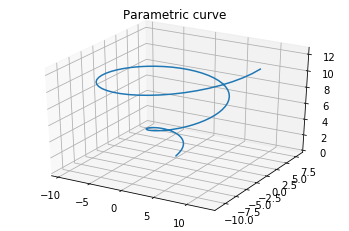

In [0]:
# Define paramter range
t = np.linspace(0, 4*np.pi, 100)

# Define the curve
x = t*np.cos(t)
y = t*np.sin(t)
z = t

fig = plt.figure(6)
ax = fig.gca(projection = '3d')
ax.plot(x, y, z)
plt.title('Parametric curve')
plt.show()